# Chapter 3 - Computer Vision

### Importing torchvision Libraries 

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets 
from torchvision import transforms 
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt 
print(torch.__version__,torchvision.__version__)

2.2.1+cu121 0.17.1+cu121


## 1.Getting a dataset (FashionMNIST)

In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train = True,
    download = False,
    transform = ToTensor(),
    target_transform = None
) 

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = False,
    transform = ToTensor(),
    target_transform=None
)

In [4]:
len(train_data),len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
image,label = train_data[0]
print(f"{image.shape}->(color_channels,height,width)")
print(f"{label} = class name index, \"{class_names[label]}\"")

torch.Size([1, 28, 28])->(color_channels,height,width)
9 = class name index, "Ankle boot"


* color channel is 1 because fashionMNIST images are black and white
* 28,28 is height and width

### Visualize the data

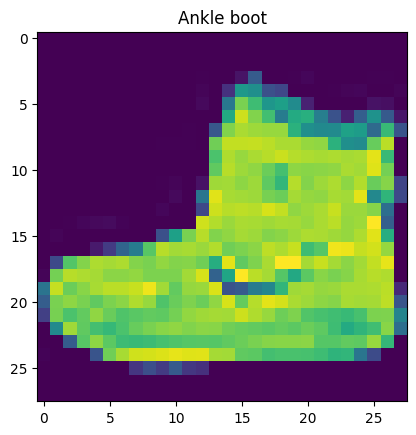

In [7]:
plt.title(class_names[label])
plt.imshow(image.squeeze())
#Matplotlib only accepts image in format Height * Widht * Color(Optional)

(-0.5, 27.5, 27.5, -0.5)

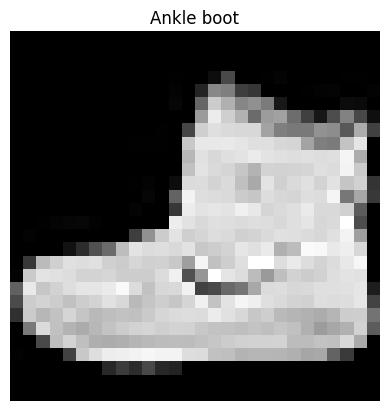

In [8]:
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False)

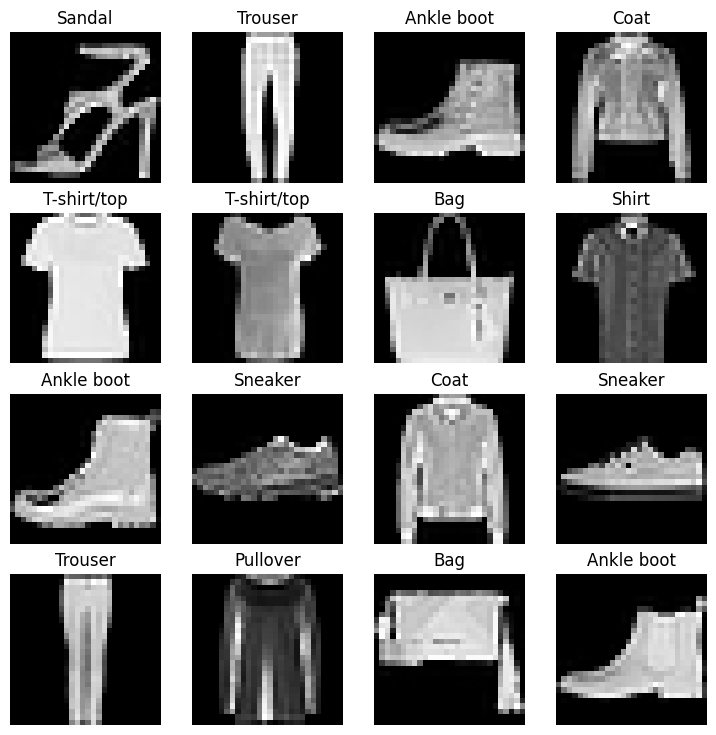

In [9]:
#Plotting more random images
# torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_i = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[random_i]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="grey")
    plt.title(class_names[label])
    plt.axis(False)

## 2.Preparing Dataloader
* Data loader converts data -> Python iterable
* We need to make data -> mini batches
  * use computer memory efficiently
  * memory can't store thousands/millions of data at once
* Mini-batches give NN better change to update gradients per epoch

In [10]:
from torch.utils.data import DataLoader
BATCH = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size =BATCH ,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size = BATCH,
                              shuffle=False)

In [11]:
len(train_dataloader),len(test_dataloader)

(1875, 313)

In [12]:
#Whats inside dataloder? (Showing contents of a single batch)
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label:0


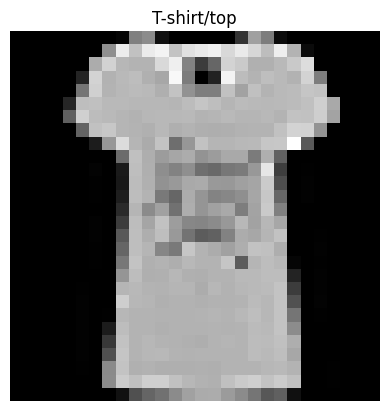

In [13]:
#Selecting a random sample from batch
random_i = torch.randint(low=0,
                         high=len(train_features_batch), #32
                         size=[1]).item()
img,label = train_features_batch[random_i],train_labels_batch[random_i]

plt.imshow(img.squeeze(),cmap='grey')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label:{label}")

## 3.Model0: Build a baseline model
* Build simple model first
* Improve it by adding further complexity if it's not doing well

In [14]:
# Creating flatten layer:
flatten = nn.Flatten()

x = train_features_batch[0] # Single sample
output = flatten(x) 

print(f"unflattened: {x.shape}->Color x Height x Width")
print(f"flattened: {output.shape}->Color x Height * Width")

unflattened: torch.Size([1, 28, 28])->Color x Height x Width
flattened: torch.Size([1, 784])->Color x Height * Width


In [15]:
from torch import nn
class FMNISTmodel0(nn.Module):
    def __init__(self,input,hidden,output):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input,out_features=hidden),
            nn.Linear(in_features = hidden,out_features=output)
        )
    def forward(self,x):
        return self.layer_stack(x)
        

In [16]:
torch.manual_seed(42)
model0=FMNISTmodel0(
    input=784,
    hidden=10,
    output=len(class_names))
model0

FMNISTmodel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand(size=(1,1,28,28))
model0(dummy_x).shape #Correct logits shape

torch.Size([1, 10])

In [18]:
model0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### Loss function, Optimizer and Metrics

In [19]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(),lr=0.1)

In [20]:
#Timer function
from timeit import default_timer as timer
def print_train_time(start:float,end:float):
    time = end-start
    print(f"Training time: {time:.2f} seconds")
    return time 

In [21]:
start_time = timer()
end_time = timer()
print_train_time(start_time,end_time)

Training time: 0.00 seconds


3.23000131174922e-05

### Creating training loop and training batches 
* Updating model parameters after batches instead of epochs

In [44]:
from tqdm.auto import tqdm

torch.manual_seed(42)
start_time = timer()

epochs = 3
###Epoch loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    ###Training
    train_loss = 0.0
    #Training Batch loop
    for batch,(X,y) in enumerate(train_dataloader):
        model0.train()
        #1. Forward pass
        y_preds = model0(X)
        #2. Calculate loss
        loss = loss_fn(y_preds,y)
        train_loss += loss
        #3.Optimizer zero grad
        optimizer.zero_grad()
        #4.Backward pass
        loss.backward()
        #5.Optimizer step
        optimizer.step()
        #Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

    #Calculate average loss outside of training loop
    train_loss /= len(train_dataloader)  

    ###Testing
    test_loss,test_acc = 0.0,0.0
    model0.eval()
    with torch.inference_mode():
        #Testing Batch loop
        for X_test,y_test in test_dataloader:
            test_preds = model0(X_test)
            test_loss += loss_fn(test_preds,y_test)
            test_acc += accuracy_fn(y_true=y_test,y_pred=test_preds.argmax(dim=1))

        #Calculate average loss and accuracy outside of test loop
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        #Print out whats happening
        print(f"train_loss:{train_loss:.4f} | test_loss:{test_loss:.4f} | test_acc:{test_acc:.4f}")
        print()

end_time = timer()
total_train_time_model0=print_train_time(start_time,end_time)
 

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:12<00:25, 12.53s/it]

train_loss:0.4440 | test_loss:0.4651 | test_acc:83.6462

Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:25<00:12, 12.51s/it]

train_loss:0.4366 | test_loss:0.4645 | test_acc:83.8858

Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:37<00:00, 12.40s/it]

train_loss:0.4305 | test_loss:0.4659 | test_acc:83.9257

Training time: 37.20 seconds


In [23]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            preds = model(X)
            loss += loss_fn(preds,y)
            acc += accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name":model.__class__.__name__,"loss":loss,"accuracy":acc}


In [24]:
eval_model(model0,test_dataloader,loss_fn,accuracy_fn)


{'model_name': 'FMNISTmodel0',
 'loss': tensor(0.4766),
 'accuracy': 83.42651757188499}

## 4. Model 1: Adding to baseline model

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Non-linear model 

In [26]:
torch.manual_seed(42)
class FMNISTmodel1(nn.Module):
    def __init__(self,input,hidden,output):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features = hidden,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features = hidden,out_features=output)
        )
    def forward(self,x):
        return self.layer_stack(x)

In [27]:
torch.manual_seed(42)
model1 = FMNISTmodel1(input=28*28,hidden=10,output=len(class_names)).to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

### Loss function and optimizer, eval metrics 

In [28]:
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(),lr=0.1)

### Functionizing training and testing loops

In [29]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):
    model.train()
    train_loss,train_acc = 0.0,0.0
    for batch,(X,y) in enumerate(dataloader):
        #Put data into target device
        X,y = X.to(device),y.to(device)
        #1. Forward pass
        preds = model(X)
        #2. Calculate loss
        loss = loss_fn(y_preds,y)
        train_loss += loss
        train_acc+= accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))
        #3.Optimizer zero grad
        optimizer.zero_grad()
        #4.Backward pass
        loss.backward()
        #5.Optimizer step
        optimizer.step()
       

    #Calculate average loss and accuracy outside of training loop
    train_loss /= len(dataloader) 
    train_acc /= len(dataloader) 
    print(f"train_loss:{train_loss:.4f} | train_acc:{train_acc:.4f}")


In [ ]:
#Functionize testing loop similar to train_step
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device=device):
    model.eval()
    test_loss,test_acc = 0.0,0.0
    with torch.inference_mode():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds,y)
            test_acc += accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    print(f"test_loss:{test_loss:.4f} | test_acc:{test_acc:.4f}")
    